# Introduction
In this notebook, we anaylze our national dataset to look for name trends.

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import mplcursors
import plotly.express as px
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display, HTML
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

## Load Data

In [2]:
#Load national data from SSA
national_df = pd.read_csv("Data/national_data.csv")
#Load state data from SSA
states_df = pd.read_csv("Data/states_data.csv")

national_df.head()

,name,sex,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


### Trends in Names Over Time

In [3]:
#Create function to plot a single name over time
def plot_name_trend(df, name_to_plot):
    """
    Plot the trend of a specific name over time.

    Parameters:
        df (DataFrame): DataFrame containing name data.
        name_to_plot (str): Name for which the trend will be plotted.
    """
    # Filter data for the specified name
    name_data = df[df['name'] == name_to_plot]
    
    # Aggregate counts by year
    name_counts_by_year = name_data.groupby('year')['count'].sum().reset_index()

    # Plot the trend
    plt.figure(figsize=(10, 6))
    plt.plot(name_counts_by_year['year'], name_counts_by_year['count'], marker='o')

    # Add labels and title
    plt.title(f'Trend of Name "{name_to_plot}" Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

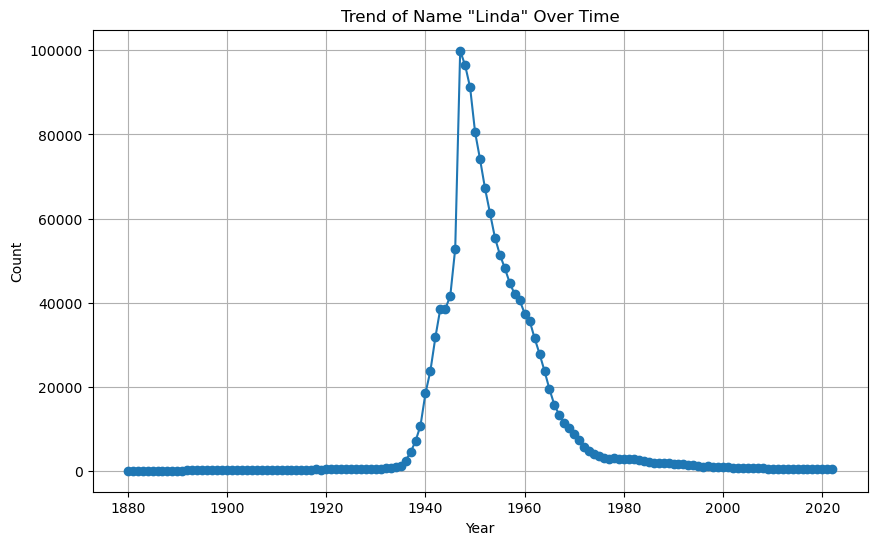

In [4]:
# Plot example name
plot_name_trend(national_df, 'Linda')

### Data by Name and Gender

In [5]:
def plot_name_over_time(df, name):
    """
    Plot occurrences of a single name by sex over time. 

    Parameters:
        df (DataFrame): DataFrame containing name data.
        name (str): Name in dataset
    """
    # Filter data for the specified name and separate by sex
    male_data = df[(df['name'] == name) & (df['sex'] == 'M')]
    female_data = df[(df['name'] == name) & (df['sex'] == 'F')]

    # Set custom colors for male and female
    colors = {'M': '#000080',  # Navy Blue for 'M'
              'F': '#FF69B4'}  # Hot Pink for 'F'

    # Plot occurrences over time for male and female
    plt.figure(figsize=(10, 6))
    plt.plot(male_data['year'], male_data['count'], label='Male', color=colors['M'])
    plt.plot(female_data['year'], female_data['count'], label='Female', color=colors['F'])
    
    # Add labels and title
    plt.title(f'Differences of Name "{name}" by Sex Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

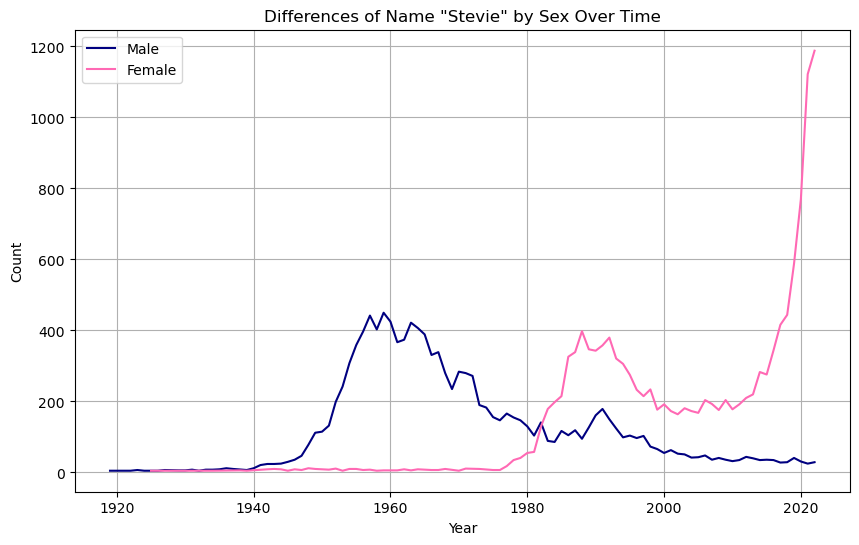

In [12]:
plot_name_over_time(national_df, 'Stevie')

In [7]:
def compare_names_across_genders(df, names_to_compare):
    """
    Compare the popularity of multiple names across genders.

    Parameters:
        df (DataFrame): DataFrame containing name data.
        names_to_compare (list): List of names to compare.
    """
    # Filter data for the specified names
    filtered_data = df[df['name'].isin(names_to_compare)]

    # Set custom color palette
    colors = {'M': '#000080',  # Navy Blue for 'M'
              'F': '#FF69B4'}  # Hot Pink for 'F'

    # Plot the comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(data=filtered_data, x='name', y='count', hue='sex', palette=colors)
    plt.title('Popularity of Names Across Genders')
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.legend(title='Gender')
    plt.grid(True)
    plt.show()


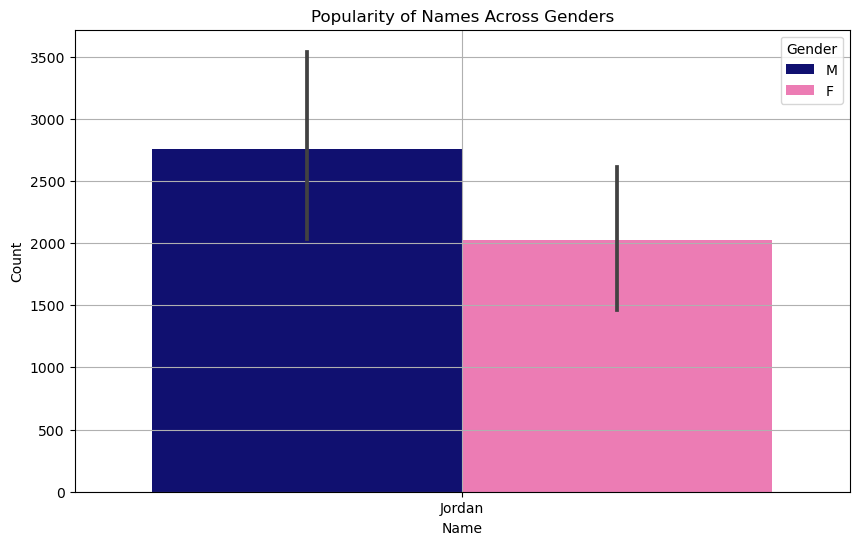

In [8]:
# Plot example names
compare_names_across_genders(national_df, ['Jordan', 'Jordan'])

### Top Names per Year

In [12]:
def plot_top_names_in_year(names_df, selected_year, sex=None, N=10):
    """
    Plot the top N names in a specific year for a specified sex ('M', 'F', or None for both).

    Parameters:
        names_df (DataFrame): DataFrame containing name data.
        selected_year (int): Year for which to plot the top names.
        sex (str or None): Sex for which to plot the top names ('M', 'F', or None for both). Default is None.
        N (int): Number of top names to display (default is 10).
    """
    # Define color palette for each sex
    colors = {'M': '#000080',  # Navy Blue for 'M'
              'F': '#FF69B4'}  # Hot Pink for 'F'

    # Select data for the specified year and sex
    if sex:
        selected_year_data = names_df[(names_df['year'] == selected_year) & (names_df['sex'] == sex)]
    else:
        selected_year_data = names_df[names_df['year'] == selected_year]
        
    # Check if the selected_year_data is empty
    if selected_year_data.empty:
        print(f"No data available for the selected year {selected_year} and sex {sex}.")
        return

    # Group by name and sum counts, then select the top N names
    top_names = selected_year_data.groupby('name')['count'].sum().sort_values(ascending=False).head(N)

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    if sex is None:
        color_palette = ['#808080'] * N  # Default color: Gray
    else:
        color_palette = [colors[sex] for _ in range(N)]
    sns.barplot(x=top_names.index, y=top_names.values, palette=color_palette, order=top_names.index)
    plt.title(f'Top {N} Names in {selected_year} ({sex if sex else "Both Sexes"})')
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

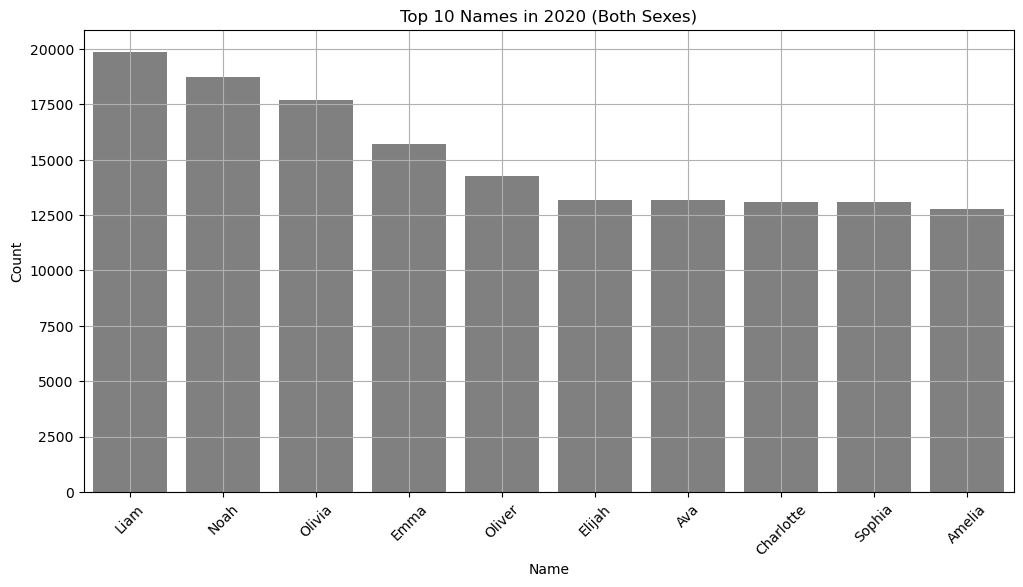

In [13]:
plot_top_names_in_year(national_df, 2020, sex=None, N=10)

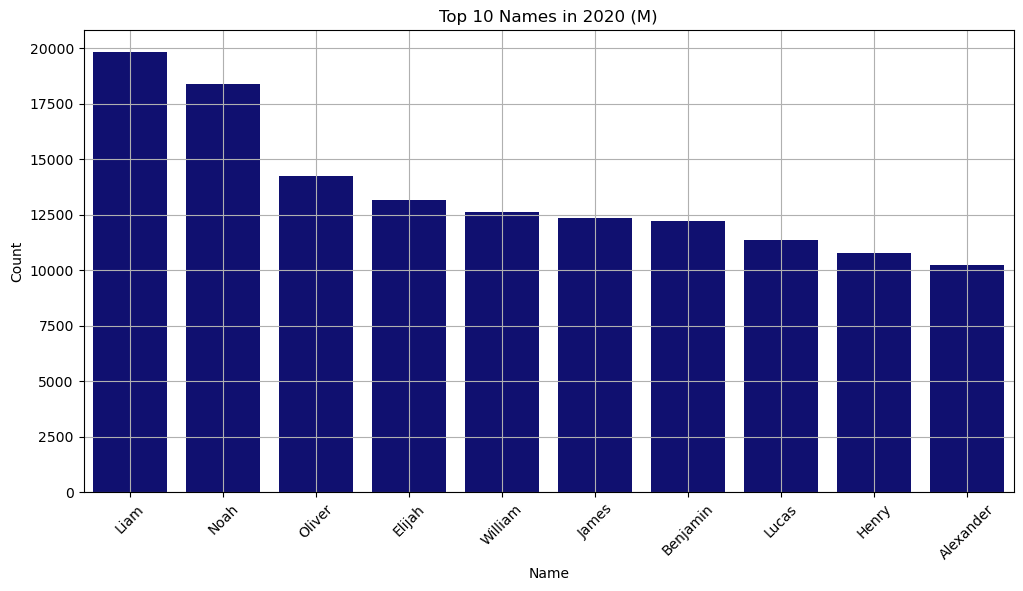

In [15]:
plot_top_names_in_year(national_df, 2020, sex='M', N=10)

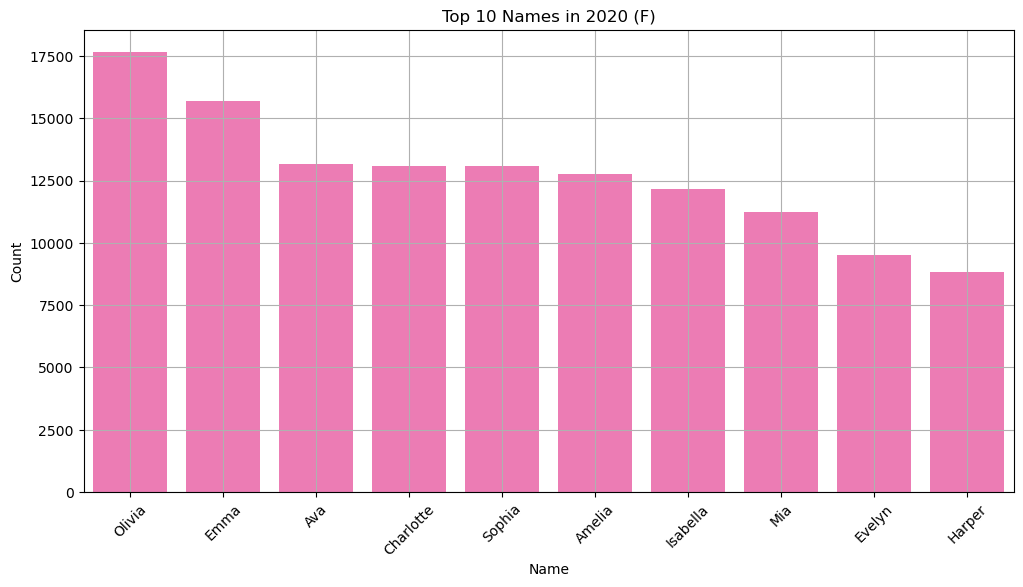

In [16]:
plot_top_names_in_year(national_df, 2020, sex='F', N=10)

### Create Dropdown

In [17]:
# Create a function to get the top 10 names for a given year and sex
def get_top_names(year):
    top_male_names = national_df[(national_df['sex'] == 'M') & (national_df['year'] == year)].nlargest(10, 'count')['name'].tolist()
    top_female_names = national_df[(national_df['sex'] == 'F') & (national_df['year'] == year)].nlargest(10, 'count')['name'].tolist()
    return top_male_names, top_female_names

# Create widget for selecting year
year_dropdown = widgets.Dropdown(options=national_df['year'].unique(), description='year:')

# Create function that updates the output widget when the year is changed
def update_output(year):
    top_male_names, top_female_names = get_top_names(year)
    output_widget.clear_output()
    with output_widget:
        display(HTML(f'<h3>Top 10 Male Names for {year}</h3><ul><li>{"</li><li>".join(top_male_names)}</li></ul>'))
        display(HTML(f'<h3>Top 10 Female Names for {year}</h3><ul><li>{"</li><li>".join(top_female_names)}</li></ul>'))

# Create an output widget for displaying the top names
output_widget = widgets.Output()

# Display the widgets
display(year_dropdown)
display(output_widget)

# Call the update_output function when the year is changed
widgets.interactive(update_output, year=year_dropdown)

Dropdown(description='year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,…

Output()

interactive(children=(Dropdown(description='year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1…

### Names with biggest increases

In [18]:
# Calculate the total count of each name for each year and sex
name_counts = national_df.groupby(['name', 'sex', 'year']).sum().reset_index()

# Calculate the percentage increase of each name from one year to the next
name_counts['percentage_increase'] = name_counts.groupby(['name', 'sex'])['count'].pct_change()

# Find the names with the highest percentage increase over time for both males and females
top_male_names = name_counts[name_counts['sex'] == 'M'].nlargest(10, 'percentage_increase')
top_female_names = name_counts[name_counts['sex'] == 'F'].nlargest(10, 'percentage_increase')

# Display the top male and female names with the biggest increases over time
print("Top 10 Male Names with the Biggest Increases Over Time:")
print(top_male_names[['name', 'percentage_increase']])

print("\nTop 10 Female Names with the Biggest Increases Over Time:")
print(top_female_names[['name', 'percentage_increase']])

Top 10 Male Names with the Biggest Increases Over Time:
             name  percentage_increase
1531941   Omarion            82.600000
1182705     Lavar            54.800000
864347     Jaheim            54.400000
59947    Alexande            49.166667
1898294     Tevin            45.692308
874387      Jalen            39.800000
506824     Demond            39.300000
974004     Jonael            37.666667
643317     Ermias            33.800000
938268   Jermaine            33.200000

Top 10 Female Names with the Biggest Increases Over Time:
            name  percentage_increase
1461145    Nakia           161.142857
902223   Jaslene            99.200000
1849306  Tabatha            99.000000
335949    Catina            96.928571
508748    Deneen            71.909091
42630    Akeelah            66.166667
1338     Aaliyah            64.954545
1118384   Kizzie            56.200000
1862115  Tamatha            43.400000
412605   Coraima            43.200000


### Create Wordcloud of Top Names from Ten Years of Data

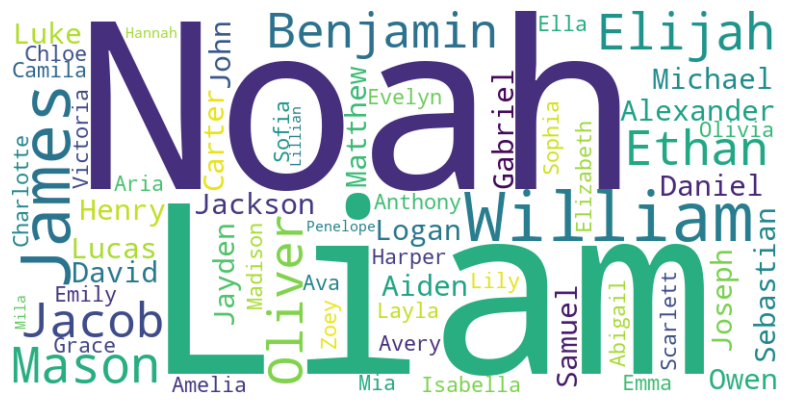

In [33]:
# Filter for male names in last decade
male_names_last_ten_years = national_df[(national_df['year'] >= 2013) & (national_df['sex'] == 'M')]

# Group by name and sum counts
top_male_names_last_ten_years = male_names_last_ten_years.groupby('name')['count'].sum().nlargest(30)

# Get list of top 10 male names
list_of_top_male_names_last_ten_years = top_male_names_last_ten_years.index.tolist()

# Filter for female names in last decade
female_names_last_ten_years = national_df[(national_df['year'] >= 2013) & (national_df['sex'] == 'F')]

# Group by name and sum counts
top_female_names_last_ten_years = female_names_last_ten_years.groupby('name')['count'].sum().nlargest(30)

# Get the list of top 10 female names
list_of_top_female_names_last_ten_years = top_female_names_last_ten_years.index.tolist()

#Combine male and female lists into one
combined_list = list_of_top_male_names_last_ten_years + list_of_top_female_names_last_ten_years

# Convert combined list of names into a string
text = ' '.join(combined_list)

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()